In [1]:
import numpy as np
from tensorflow.python import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import activations
from tensorflow.python.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Read Data
data = pd.read_csv("YESBANK.NS.csv")
#Display top 10 rows
data.head()

In [68]:
#we delete the columns date and close because we are predicting the closing price
ds = data.drop(['Date', 'Close'], axis=1).fillna(0).to_numpy().reshape((-1, 5, 1))
#fill = it wil remove all the null values
#numpy = it will convert the pandas data frame  to numpy ND array
# reshape = used to increase the dimension by one so that it can be used conv 1D layer
ds = np.hstack([ds, np.zeros((ds.shape[0], 3,1))]).astype(np.float32)
#hstack = used to append 3 column to zeros so that data shape is compliant to auto encoder
# as type = used to convert all int values to float
ds = ds - np.mean(ds, axis=0, keepdims=True)
# normal mean
ds[:, 4, :] /= 214860840
# normalize the normal column of volume

In [69]:
ds.shape

(496, 8, 1)

In [58]:
#encoder model
enc = models.Sequential([
    layers.InputLayer((8, 1)),
    layers.Conv1D(filters=3, kernel_size=3, padding='same'),
    layers.MaxPool1D(pool_size=2),
    layers.Conv1D(filters=3, kernel_size=3, padding='same'),
    layers.MaxPool1D(pool_size=2),
    layers.Conv1D(filters=3, kernel_size=3, padding='same'),
    layers.MaxPool1D(pool_size=2),
    layers.Conv1D(filters=1, kernel_size=3, padding='same'),
])
enc.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 8, 3)              12        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 4, 3)              0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 4, 3)              30        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 2, 3)              0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 2, 3)              30        
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 1, 3)              0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 1, 1)            

In [59]:

#decoder part
dec = models.Sequential([
    layers.InputLayer((1, 1)),
    layers.Conv1D(filters=3, kernel_size=3, padding='same'),
    layers.UpSampling1D(size=2),
    layers.Conv1D(filters=3, kernel_size=3, padding='same'),
    layers.UpSampling1D(size=2),
    layers.Conv1D(filters=3, kernel_size=3, padding='same'),
    layers.UpSampling1D(size=2),
    layers.Conv1D(filters=1, kernel_size=3, padding='same'),
])
dec.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 1, 3)              12        
_________________________________________________________________
up_sampling1d_9 (UpSampling1 (None, 2, 3)              0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 2, 3)              30        
_________________________________________________________________
up_sampling1d_10 (UpSampling (None, 4, 3)              0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 4, 3)              30        
_________________________________________________________________
up_sampling1d_11 (UpSampling (None, 8, 3)              0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 8, 1)            

In [98]:
#this is a model which combines the encoder and decoder so that we can train the encoder
encoder_trainer = models.Sequential([
    layers.InputLayer((8, 1)),
    enc,
    dec
])
encoder_trainer.compile(
    # optimizer=optimizers.rmsprop_v2.RMSprop(learning_rate=0.00001),
    optimizer=optimizers.adam_v2.Adam(learning_rate=0.00001),
    loss=losses.MSE,
    metrics=['mape', 'mae']
)

In [99]:
enc.trainable = True
h = encoder_trainer.fit( x=ds, y=ds,epochs=100)

Epoch 1/100
16/16 [==============================] - 0s 1ms/step - loss: 13.0373 - mape: 543227.4375 - mae: 1.6318
Epoch 2/100
16/16 [==============================] - 0s 1ms/step - loss: 12.9060 - mape: 754167.8750 - mae: 1.6243
Epoch 3/100
16/16 [==============================] - 0s 1ms/step - loss: 12.7690 - mape: 1308141.2500 - mae: 1.6168
Epoch 4/100
16/16 [==============================] - 0s 1ms/step - loss: 12.6413 - mape: 1953502.5000 - mae: 1.6095
Epoch 5/100
16/16 [==============================] - 0s 1ms/step - loss: 12.5049 - mape: 2691993.2500 - mae: 1.6018
Epoch 6/100
16/16 [==============================] - 0s 997us/step - loss: 12.3707 - mape: 3416235.7500 - mae: 1.5944
Epoch 7/100
16/16 [==============================] - 0s 1ms/step - loss: 12.2457 - mape: 4116157.2500 - mae: 1.5872
Epoch 8/100
16/16 [==============================] - 0s 1ms/step - loss: 12.1122 - mape: 4835249.5000 - mae: 1.5797
Epoch 9/100
16/16 [==============================] - 0s 1ms/step - loss:

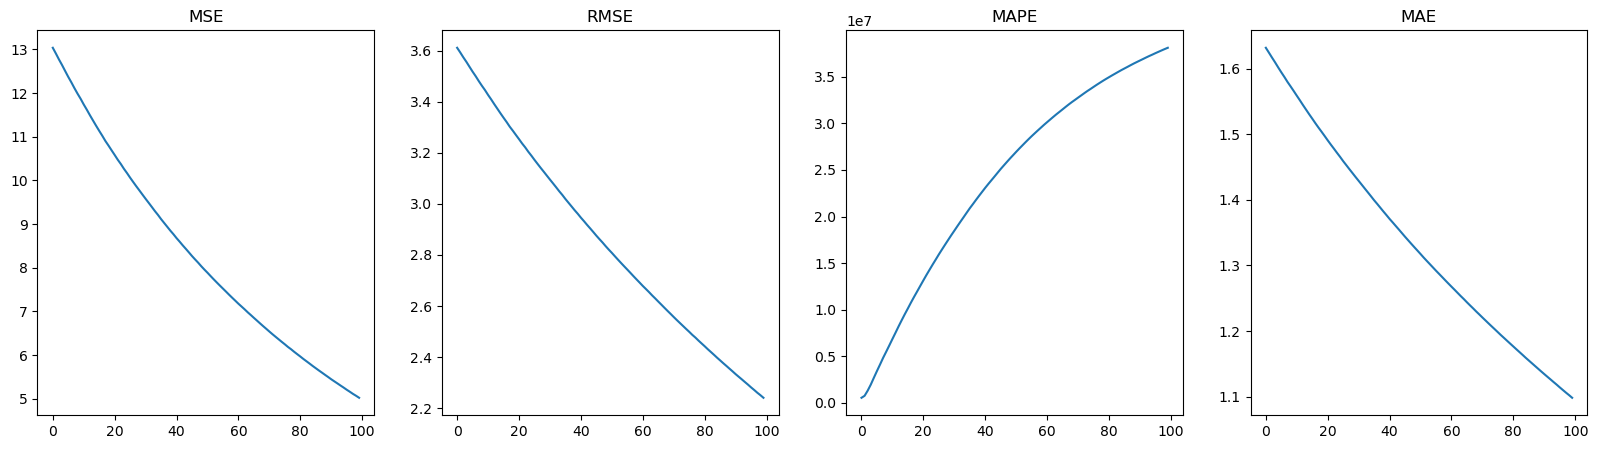

In [100]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].plot(h.history['loss'])
axs[0].set_title('MSE')
axs[1].plot(np.sqrt(h.history['loss']))
axs[1].set_title('RMSE')
axs[2].plot(h.history['mape'])
axs[2].set_title('MAPE')
axs[3].plot(h.history['mae'])
axs[3].set_title('MAE')
plt.show()

In [82]:

#predictor part
pre = models.Sequential([
    layers.InputLayer((1, 1)),
    layers.Conv1D(filters=3, kernel_size=3, padding='same'),
    layers.UpSampling1D(size=2),
    layers.Conv1D(filters=3, kernel_size=3, padding='same'),
    layers.UpSampling1D(size=2),
    layers.Conv1D(filters=3, kernel_size=3, padding='same'),
    layers.MaxPool1D(pool_size=2),
    layers.Conv1D(filters=1, kernel_size=3, padding='same'),
    layers.MaxPool1D(pool_size=2),
])
pre.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 1, 3)              12        
_________________________________________________________________
up_sampling1d_12 (UpSampling (None, 2, 3)              0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 2, 3)              30        
_________________________________________________________________
up_sampling1d_13 (UpSampling (None, 4, 3)              0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 4, 3)              30        
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2, 3)              0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 2, 1)            

In [91]:
yd = data['Close'].fillna(0).to_numpy().reshape((-1, 1, 1))
yd.shape

(496, 1, 1)

In [94]:
predictor_trainer = models.Sequential([
    layers.InputLayer((8, 1)),
    enc,
    pre
])
predictor_trainer.compile(
    optimizer=optimizers.adam_v2.Adam(learning_rate=0.0001),
    loss=losses.MSE,
    metrics=['mape', 'mae']
)

In [ ]:
enc.trainable = False
h = predictor_trainer.fit(
    x=ds, y=yd,
    epochs=100
)

Epoch 1/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2769 - mape: 2.5553 - mae: 0.3554
Epoch 2/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2384 - mape: 2.1564 - mae: 0.2927
Epoch 3/100
16/16 [==============================] - 0s 993us/step - loss: 0.2331 - mape: 2.1094 - mae: 0.2854
Epoch 4/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2302 - mape: 2.0862 - mae: 0.2812
Epoch 5/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2295 - mape: 2.0817 - mae: 0.2806
Epoch 6/100
16/16 [==============================] - 0s 934us/step - loss: 0.2287 - mape: 2.0712 - mae: 0.2796
Epoch 7/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2281 - mape: 2.0636 - mae: 0.2785
Epoch 8/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2277 - mape: 2.0640 - mae: 0.2784
Epoch 9/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2271 - mape: 2.0658 - mae: 0.2788
Epoch 10/100
16

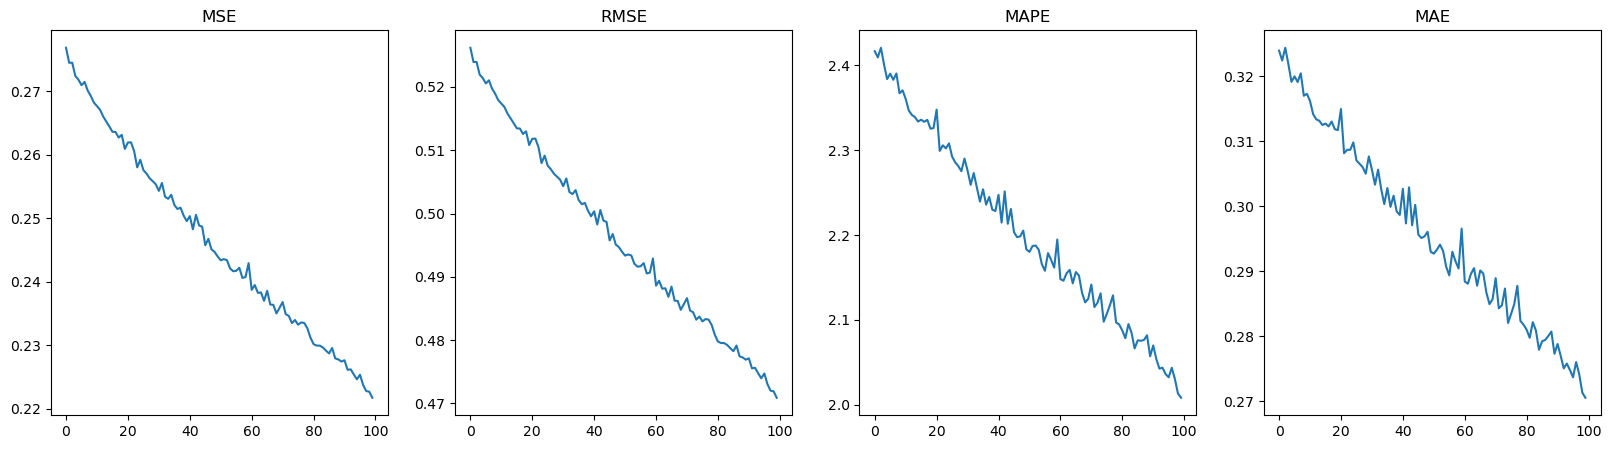

In [96]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].plot(h.history['loss'])
axs[0].set_title('MSE')
axs[1].plot(np.sqrt(h.history['loss']))
axs[1].set_title('RMSE')
axs[2].plot(h.history['mape'])
axs[2].set_title('MAPE')
axs[3].plot(h.history['mae'])
axs[3].set_title('MAE')
plt.show()